In [1]:
import pyro
import pyro.infer
import pyro.optim
import torch
import numpy as np
import scipy.stats as stats
import torch.distributions.constraints as constraints
import matplotlib.pyplot as plt

In [2]:
# In the meantime I'll define thin wrappers around the probability distributions
class Bernoulli:
    def __init__(self, p):
        self.p = p
    
    def sample(self, size=1):
        return stats.bernoulli.rvs(p=self.p, size=size)
        
class Uniform:
    def __init__(self, start, end):
        self.start = start
        self.end = end
    
    def sample(self, size=1):
        return stats.uniform.rvs(loc=self.start, scale=self.end-self.start, size=size)
    
    def pdf(self, x):
        return stats.uniform.pdf(x, loc=self.start, scale=self.end-self.start)
    
    def mean(self):
        return stats.uniform.mean(loc=self.start, scale=self.end-self.start)
        
class Beta:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    def pdf(self, X):
        return stats.beta.pdf(X, a=self.alpha, b=self.beta)
    
    def mean(self):
        return stats.beta.mean(a=self.alpha, b=self.beta)
    
    
class Normal:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def pdf(self, X):
        return stats.norm.pdf(X, loc=self.mu, scale=self.sigma)
    
    def sample(self, size=1):
        return stats.norm.rvs(loc=self.mu, scale=self.sigma, size=size)
    
    def mean(self):
        return self.mu

In [3]:
plt.rcParams['figure.figsize'] = [14, 8]

# Second example - continuous case

- Prior $\mathbb{P}(\theta) \sim N(0, 1)$
- Likelihood $\mathbb{P}(X | \theta) \sim N(\theta, 1)$

In [4]:
N = 100

In [5]:
Prior = Normal(0, 1)

In [6]:
#hidden_theta = Prior.sample()[0]
#print("hidden_theta=", hidden_theta)
#Likelihood = Normal(hidden_theta, 1)
#X = Likelihood.sample(N)

In [7]:
hidden_theta = -0.30876849393399736
X = np.array([ 0.83882339, -0.18327733, -2.1367785 , -0.23884984,  0.64975018,
        0.3822017 , -1.28156452, -1.76602789, -0.52034258, -1.02277046,
       -0.1081116 , -0.04086724, -1.00239476, -2.31659967, -2.01284933,
       -0.04255648, -0.48477407, -0.85343536,  0.57087556, -1.67664997,
       -0.16917258,  0.33454645, -1.7441229 ,  1.04228389,  0.33730209,
        0.85081516,  0.16614794, -0.87870244,  0.22860209, -1.12077229,
        0.00912435, -1.34767148, -1.06479637,  0.51134094,  1.65901749,
       -1.00470063,  0.88676986,  0.0328493 , -0.53138992, -0.26180192,
       -0.18376393, -1.06245679,  1.33091922, -1.14943535, -0.03175903,
       -0.29296988,  0.76961376, -0.80308002, -0.59702679, -0.73219416,
        0.36688673, -1.35749804, -0.69708232,  1.08306657, -2.09771641,
       -1.50261039,  0.07427721,  0.25997902, -2.71479907,  1.45067433,
       -0.24867818, -0.25115161,  1.00637968,  0.48491776, -1.87099424,
       -0.29619929,  0.43546577,  0.24719993, -0.14766969, -1.22047931,
       -0.6958676 ,  0.50736201, -0.02641034, -0.00787796, -2.67367672,
        2.22168505, -0.45168883,  0.20791519, -0.94687149, -0.41716543,
       -1.66260982,  1.17850728, -0.04458167,  0.21673739, -0.77691316,
       -0.1035381 , -1.60944244,  1.28643517,  0.7185452 , -2.15315254,
        0.39248977, -1.88790874, -0.70113703, -0.07157591, -0.67460936,
       -1.10845035,  0.46250522,  0.45822605,  0.02116005, -0.58546019])

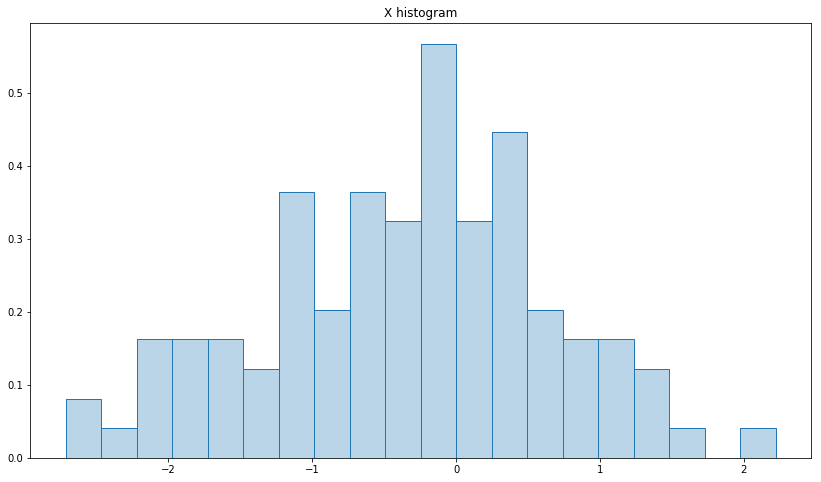

In [8]:
fig, axs = plt.subplots(1, 1)
axs.set_title("X histogram")
color = next(axs._get_lines.prop_cycler)["color"]
axs.hist(X, bins=20, density=True, color=color, alpha=0.3)
axs.hist(X, bins=20, density=True, color=color, edgecolor=color, fc="None", lw=1)
None

In [9]:
def model(size):
    theta = pyro.sample("continuous_prior", pyro.distributions.Normal(0, 1))
    
    data = pyro.sample(
        "continuous_likelihood", 
        pyro.distributions.Normal(theta, 1).expand_by([size]), 
        obs=torch.from_numpy(X).to(torch.float64)
    )
    
    print("theta=", theta)
    print("data=", data)

    return data

In [23]:
pyro.param("c_a", torch.tensor(2.0).to(torch.float64))
pyro.param("c_b", torch.tensor(4.0).to(torch.float64), constraint=constraints.positive)

tensor(1., dtype=torch.float64, grad_fn=<AddBackward0>)

In [11]:
def guide(size):
    mu = pyro.param("c_a", torch.tensor(1.0))
    std = pyro.param("c_b", torch.tensor(1.0), constraint=constraints.positive)
    print("mu=", mu)
    print("Std=", std)
    guide_sample = pyro.sample("continuous_prior", pyro.distributions.Normal(mu, std))
    
    print("guide_sample=", guide_sample)
    
    return guide_sample

In [12]:
continuous_svi = pyro.infer.SVI(
    model=model,
    guide=guide,
    optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO()
)

In [22]:
continuous_svi.evaluate_loss(size=X.size)

mu= tensor(0., dtype=torch.float64, requires_grad=True)
Std= tensor(1., dtype=torch.float64)
guide_sample= tensor(1.7372, dtype=torch.float64)
theta= tensor(1.7372, dtype=torch.float64)
data= tensor([ 0.8388, -0.1833, -2.1368, -0.2388,  0.6498,  0.3822, -1.2816, -1.7660,
        -0.5203, -1.0228, -0.1081, -0.0409, -1.0024, -2.3166, -2.0128, -0.0426,
        -0.4848, -0.8534,  0.5709, -1.6766, -0.1692,  0.3345, -1.7441,  1.0423,
         0.3373,  0.8508,  0.1661, -0.8787,  0.2286, -1.1208,  0.0091, -1.3477,
        -1.0648,  0.5113,  1.6590, -1.0047,  0.8868,  0.0328, -0.5314, -0.2618,
        -0.1838, -1.0625,  1.3309, -1.1494, -0.0318, -0.2930,  0.7696, -0.8031,
        -0.5970, -0.7322,  0.3669, -1.3575, -0.6971,  1.0831, -2.0977, -1.5026,
         0.0743,  0.2600, -2.7148,  1.4507, -0.2487, -0.2512,  1.0064,  0.4849,
        -1.8710, -0.2962,  0.4355,  0.2472, -0.1477, -1.2205, -0.6959,  0.5074,
        -0.0264, -0.0079, -2.6737,  2.2217, -0.4517,  0.2079, -0.9469, -0.4172,
        

356.7941115355813

In [ ]:
losses, a_history,b_history  = [], [], []
num_steps = 10_000
for t in range(num_steps):
    losses.append(continuous_svi.step(X.size))
    a_history.append(pyro.param("c_a").item())
    b_history.append(pyro.param("c_b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

print('mu = ', pyro.param("c_a").item())
print('std = ', pyro.param("c_b").item())

In [ ]:
plt.subplot(1,2,1)

plt.plot(a_history)
plt.plot([0,num_steps],[X.sum() / (X.size + 1), X.sum() / (X.size + 1)], 'k:')
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot(b_history)

plt.plot([0,num_steps],[1.0 / np.sqrt(X.size + 1), 1.0 / np.sqrt(X.size + 1)], 'k:')
plt.tight_layout()

In [ ]:
MU = pyro.param("c_a").item()
STD = pyro.param("c_b").item()

In [ ]:
# Analytical posterior
Prior = Normal(0, 1)
AnalyticalPosterior = Normal(X.sum() / (X.size + 1), 1.0 / np.sqrt(X.size + 1))
EstimatedPosterior = Normal(MU, STD)

In [ ]:
print(hidden_theta)
mle = AnalyticalPosterior.mean()
print(AnalyticalPosterior.mean())

In [ ]:
fig, axs = plt.subplots(1, 1)
axs.set_title("Prior vs Posterior")
support = np.linspace(-4, 4, 10_00)

axs.plot(support, Prior.pdf(support), label="Prior")
axs.fill_between(support, 0, Prior.pdf(support), alpha=0.2)
axs.plot(support, np.minimum(AnalyticalPosterior.pdf(support), 2.0), label="Analytical Posterior")
axs.fill_between(support, 0, np.minimum(AnalyticalPosterior.pdf(support), 2.0), alpha=0.2)
axs.plot(support, np.minimum(EstimatedPosterior.pdf(support), 2.0), label="Estimated Posterior")
axs.fill_between(support, 0, np.minimum(EstimatedPosterior.pdf(support), 2.0), alpha=0.2)
axs.axvline(hidden_theta, color='red', linestyle='--', label="True paramter value")
axs.axvline(mle, color='blue', linestyle='--', label="Maximum likelihood estimate")


axs.legend()
None